In [ ]:
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen

In [ ]:
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

# Get Wisconsin Breast Cancer Data
breast_cancer = pd.read_csv('/content/data-breastCancer.csv')

In [ ]:
breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
breast_cancer.set_index(['id'], inplace = True)

# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

# check mapping worked
mapping = breast_cancer[['diagnosis']]
mapping

,diagnosis
id,
842302,1
842517,1
84300903,1
84348301,1
84358402,1
...,...
926424,1
926682,1
926954,1


In [ ]:
breast_cancer.apply(lambda x: x.isnull().sum())

# drop the field we dont need
breast_cancer = breast_cancer.drop(columns=['Unnamed: 32'])

# double check the field is gone
breast_cancer.apply(lambda x: x.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [ ]:
print("Shape of our dataframe:\n",
     breast_cancer.shape)
print("data types of our columns:\n",
     breast_cancer.dtypes)

Shape of our dataframe:
 (569, 31)
data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          

In [ ]:
s = pd.value_counts(breast_cancer.diagnosis)

# for class 0
num_of_benign = s[0]
# for class 1
num_of_malignant = s[1]

total_cases = len(breast_cancer)

# calculate percentages of data that resides in both classes
percent_b = num_of_benign / total_cases
percent_m = num_of_malignant / total_cases

print("Distribution between Benign and Malignant\nPercent Benign: {0:.3f} \nPercent Malignant: {1:.3f} ".format(percent_b, percent_m))

Distribution between Benign and Malignant
Percent Benign: 0.627 
Percent Malignant: 0.373 


In [ ]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']

# train_test_split
training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20,
                                                                    random_state = 42)
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel()
test_class_set = test_class_set.values.ravel()

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)

In [ ]:
np.random.seed(42)
start = time.time()

# give to GridSearchCV
param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

# set up the GridSearch
cv_rf = GridSearchCV(rf_classifier, cv = 5,
                     param_grid=param_dist,
                     n_jobs = 3)

# fit the GridSearch
cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', cv_rf.best_params_)


end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None}
Time taken in grid search:  11.10


In [ ]:
rf_classifier.set_params(criterion = 'gini',
                  max_features = 'log2',
                  max_depth = 3,
                  )

RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=10,
                       random_state=42)

In [ ]:
rf_classifier.set_params(warm_start=True,
                  oob_score=True)

# found this from sci-kit learn https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
min_estimators = 15
max_estimators = 500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    rf_classifier.set_params(n_estimators=i)
    rf_classifier.fit(training_set, class_set)

    oob_error = 1 - rf_classifier.oob_score_
    error_rate[i] = oob_error

In [ ]:
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

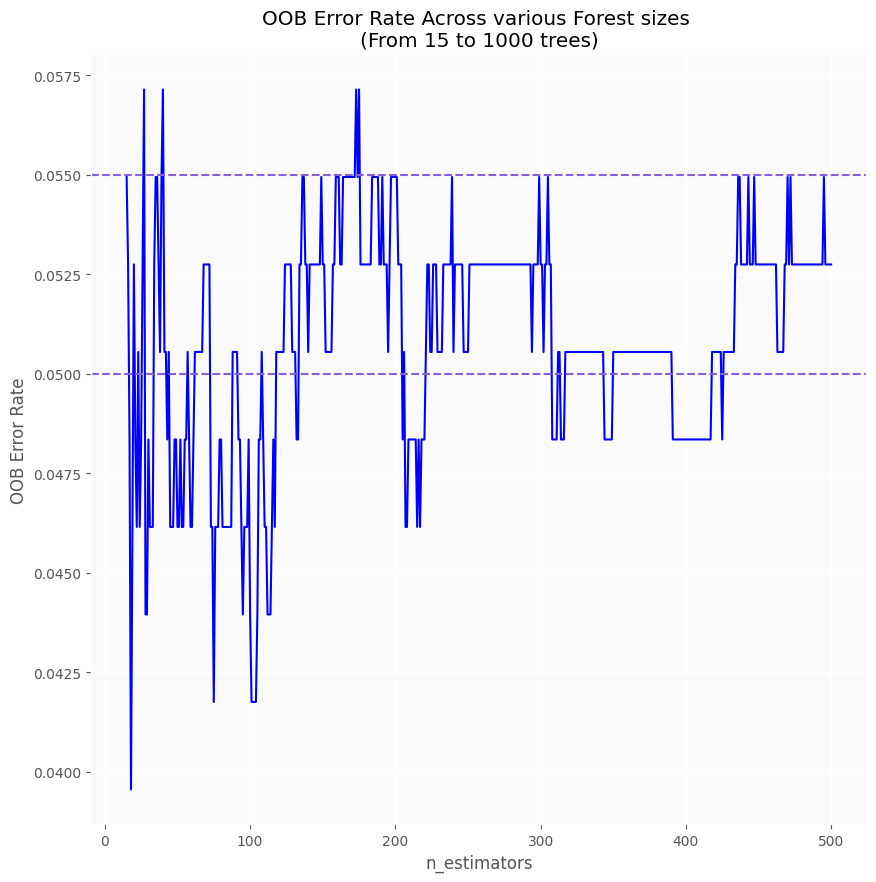

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'blue')
plt.axhline(0.055,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

In [ ]:
rf_classifier.set_params(n_estimators=420,
                  bootstrap = True,
                  warm_start=False,
                  oob_score=False)

RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=420,
                       random_state=42)

In [ ]:
rf_classifier.fit(training_set, class_set)

RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=420,
                       random_state=42)

In [ ]:
def variable_importance(fit):
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit))

        # Checks whether model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    # sort from most import to least
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [ ]:
rf_var_imp = variable_importance(rf_classifier)

rf_importances = rf_var_imp['importance']

rf_indices = rf_var_imp['index']

In [ ]:
def print_var_importance(importance, indices, name_index):
    print("Feature ranking:")
    # iterate thru variable indices
    for f in range(0, indices.shape[0]):
        i = f
        # prints the name of the feature and its importance metric
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1, names_index[indices[i]], importance[indices[f]]))

In [ ]:
names = ['id', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

names_index = names[2:]

# print out classes by importance in decending order
print_var_importance(rf_importances, rf_indices, names_index)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Impurity of 0.12769
2. The feature 'concave_points_worst' has a Mean Decrease in Impurity of 0.12202
3. The feature 'perimeter_worst' has a Mean Decrease in Impurity of 0.12197
4. The feature 'concave_points_mean' has a Mean Decrease in Impurity of 0.09623
5. The feature 'radius_worst' has a Mean Decrease in Impurity of 0.07696
6. The feature 'concavity_mean' has a Mean Decrease in Impurity of 0.06092
7. The feature 'area_mean' has a Mean Decrease in Impurity of 0.05814
8. The feature 'radius_mean' has a Mean Decrease in Impurity of 0.05507
9. The feature 'perimeter_mean' has a Mean Decrease in Impurity of 0.05026
10. The feature 'area_se' has a Mean Decrease in Impurity of 0.04166
11. The feature 'concavity_worst' has a Mean Decrease in Impurity of 0.03920
12. The feature 'compactness_worst' has a Mean Decrease in Impurity of 0.02092
13. The feature 'texture_worst' has a Mean Decrease in Impurity of 0.01663
14. The fe

In [ ]:
def variable_importance_plot(importance, indices, name_index):
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)

    feature_space = []

    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    plt.title('Feature importances for Random Forest Model\\nBreast Cancer (Diagnostic)')

    plt.barh(index,
              importance_desc,
              align="center",
              color = '#FFB6C1')
    plt.yticks(index,
                feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

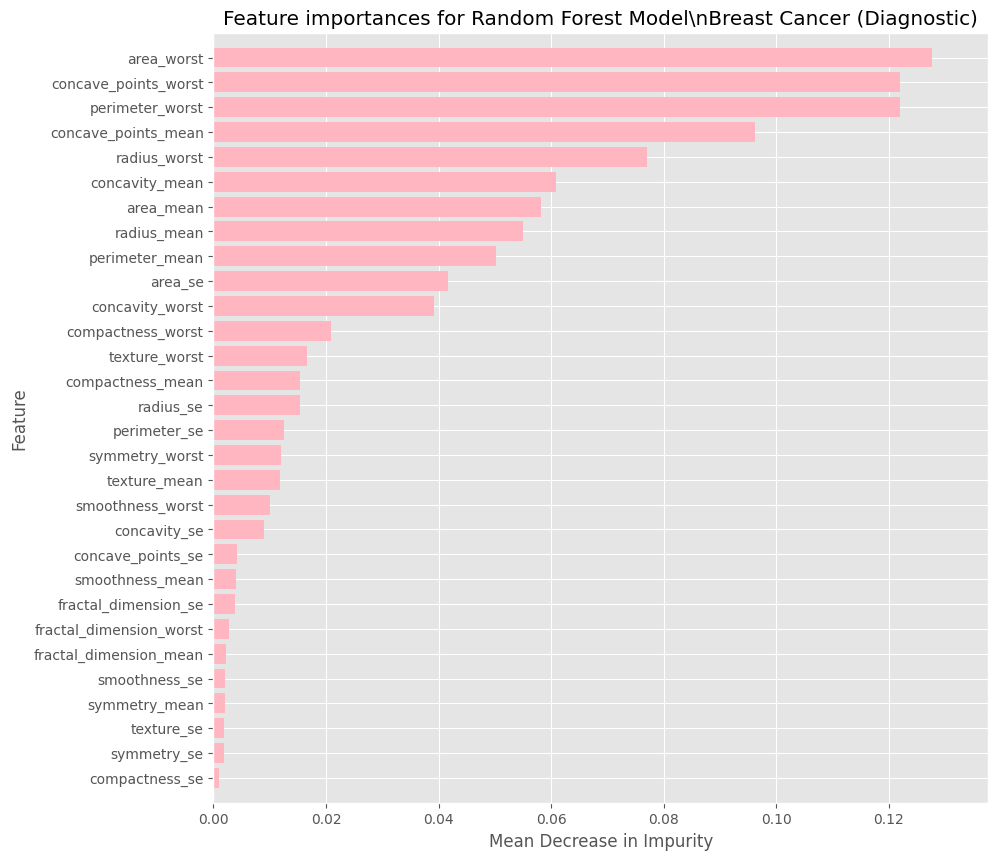

In [ ]:
variable_importance_plot(rf_importances, rf_indices, names_index)

In [ ]:
import time

def cross_val_metrics(fit, training_set, class_set, estimator, print_results = True):
    start = time.time()
    """
    Returns Mean Accurancy with standard_dev of model over Kfolds Validation
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit))

        # Checks whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    # create KFolds validation
    n = KFold(n_splits=10)

    scores = cross_val_score(fit,
                         training_set,
                         class_set,
                         cv = n)
    end = time.time()
    # print how much time the Kfolds took
    print("Time elapsed to do Cross Validation: {0:.2f} seconds.".format(end-start))
    if print_results:
        for i in range(0, len(scores)):
            # print out the scores for each validation split
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))

        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})".format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [ ]:
cross_val_metrics(rf_classifier,
                  training_set,
                  class_set,
                  'rf',
                  print_results = True)

Time elapsed to do Cross Validation: 5.87 seconds.
Cross validation run 0:  1.000
Cross validation run 1:  0.957
Cross validation run 2:  0.935
Cross validation run 3:  0.935
Cross validation run 4:  0.957
Cross validation run 5:  0.978
Cross validation run 6:  0.933
Cross validation run 7:  0.889
Cross validation run 8:  1.000
Cross validation run 9:  0.889
Accuracy:  0.947 (+/-  0.019)


In [ ]:
rf_predictions = rf_classifier.predict(test_set)

In [ ]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics; Compute a simple cross tabulation of two (or more) factors.
        # By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

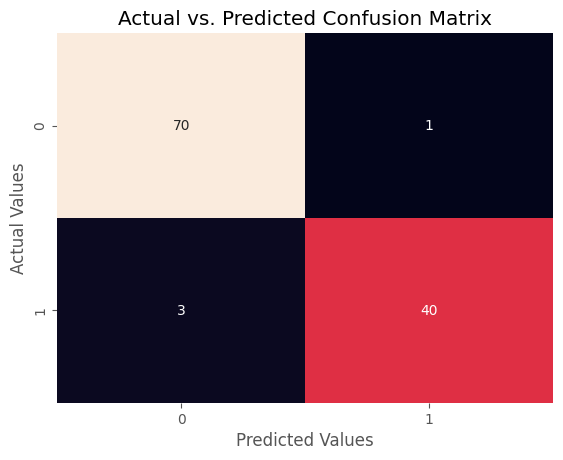

In [ ]:
conf_mat = create_conf_mat(test_class_set, rf_predictions)

# use seaborn heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [ ]:
rf_accuracy = rf_classifier.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(rf_accuracy))

Here is our mean accuracy on the test set:
 0.965


In [ ]:
rf_test_error_rate = 1 - rf_accuracy
print("The test error rate for our model is:\n {0: .4f}"\
      .format(rf_test_error_rate))

The test error rate for our model is:
  0.0351


In [ ]:
predictions_prob = rf_classifier.predict_proba(test_set)[:, 1]

# use roc_curve to produce
fpr2, tpr2, _ = roc_curve(test_class_set,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print(auc_rf)

0.9963969865705863
